In [2]:
pip install transformers datasets matplotlib seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
pip install transformers datasets torch


In [4]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [3]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

# Load IMDb dataset and tokenizer
dataset = load_dataset("imdb")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Use a smaller subset of IMDb for faster training
train_subset = dataset["train"].shuffle(seed=42).select(range(2000))  # Use only 2000 samples
test_subset = dataset["test"].shuffle(seed=42).select(range(500))     # Use only 500 samples

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_subset.map(tokenize_function, batched=True)
tokenized_test = test_subset.map(tokenize_function, batched=True)
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load a smaller model if possible
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to("cpu")

# Set up TrainingArguments with reduced steps and epochs
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,   # Smaller batch size for faster CPU training
    per_device_eval_batch_size=4,
    num_train_epochs=1,              # Train for only 1 epoch
    weight_decay=0.01,
    no_cuda=True,
    report_to="none",
    max_steps=10,                    # Train for only 10 steps
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# Train and evaluate
trainer.train()
trainer.evaluate()


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Epoch,Training Loss,Validation Loss
0,No log,0.689280


{'eval_loss': 0.6892800331115723,
 'eval_runtime': 486.2902,
 'eval_samples_per_second': 1.028,
 'eval_steps_per_second': 0.257,
 'epoch': 0.02}

Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.76      0.66       254
    Positive       0.63      0.42      0.51       246

    accuracy                           0.59       500
   macro avg       0.60      0.59      0.58       500
weighted avg       0.60      0.59      0.58       500



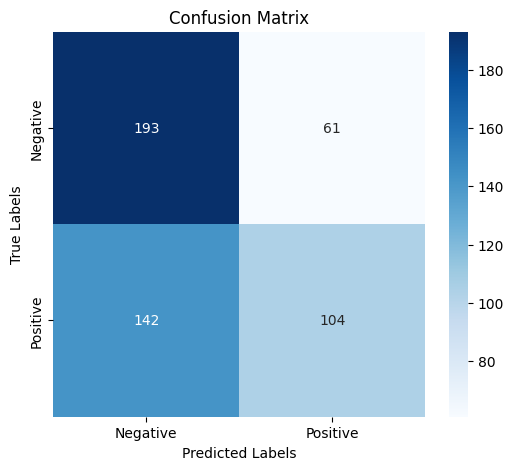

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Ensure predictions and true labels are not empty
if len(pred_labels) == 0 or len(true_labels) == 0:
    print("Error: Predictions or true labels are empty.")
else:
    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


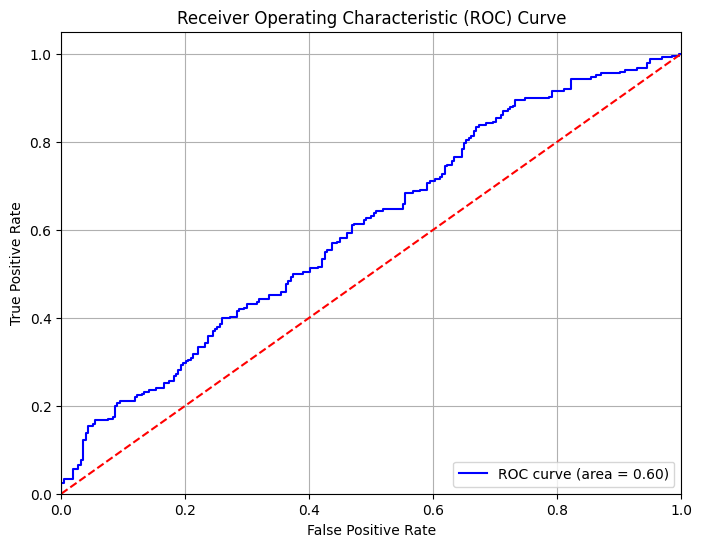

In [9]:
from sklearn.metrics import roc_curve, auc

# Get the probability predictions for the positive class
prob_predictions = predictions.predictions[:, 1]  # Probability for positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, prob_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


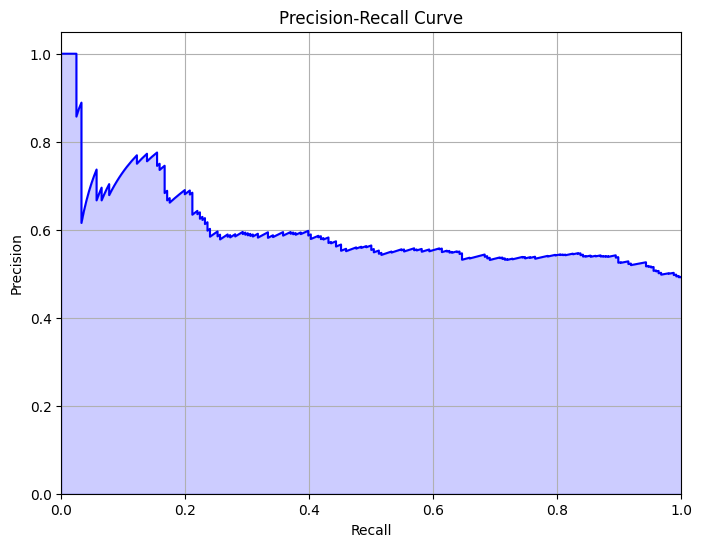

In [10]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, prob_predictions)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.fill_between(recall, precision, color='blue', alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


In [11]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# Calculate metrics
f1 = f1_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, prob_predictions)

# Print metrics
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


F1 Score: 0.5061
Accuracy: 0.5940
AUC-ROC: 0.6032


In [12]:
print("=== Model Evaluation Summary ===")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))


=== Model Evaluation Summary ===
F1 Score: 0.5061
Accuracy: 0.5940
AUC-ROC: 0.6032

Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.76      0.66       254
    Positive       0.63      0.42      0.51       246

    accuracy                           0.59       500
   macro avg       0.60      0.59      0.58       500
weighted avg       0.60      0.59      0.58       500



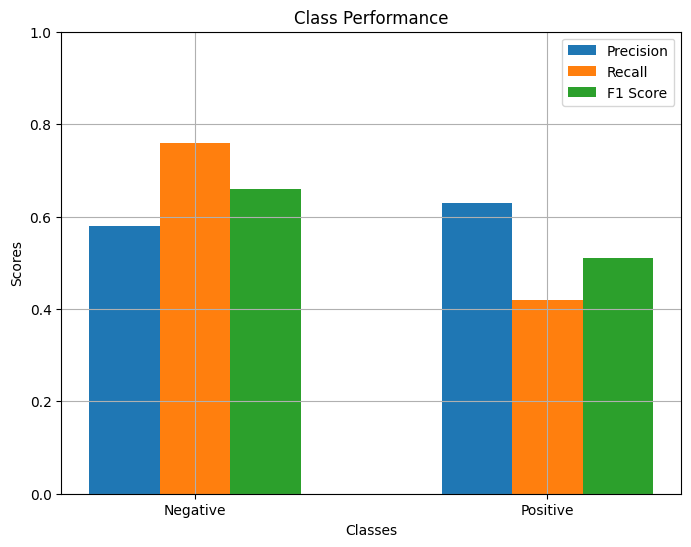

In [13]:
import pandas as pd

# Create a DataFrame for visualization
class_names = ["Negative", "Positive"]
scores = {
    "Class": class_names,
    "Precision": [0.58, 0.63],
    "Recall": [0.76, 0.42],
    "F1 Score": [0.66, 0.51]
}

performance_df = pd.DataFrame(scores)

# Set the position of the bars on the x-axis
bar_width = 0.2
x = np.arange(len(class_names))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, performance_df['Precision'], width=bar_width, label='Precision', align='center')
plt.bar(x + bar_width, performance_df['Recall'], width=bar_width, label='Recall', align='center')
plt.bar(x + 2 * bar_width, performance_df['F1 Score'], width=bar_width, label='F1 Score', align='center')

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Class Performance")
plt.xticks(x + bar_width, class_names)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()


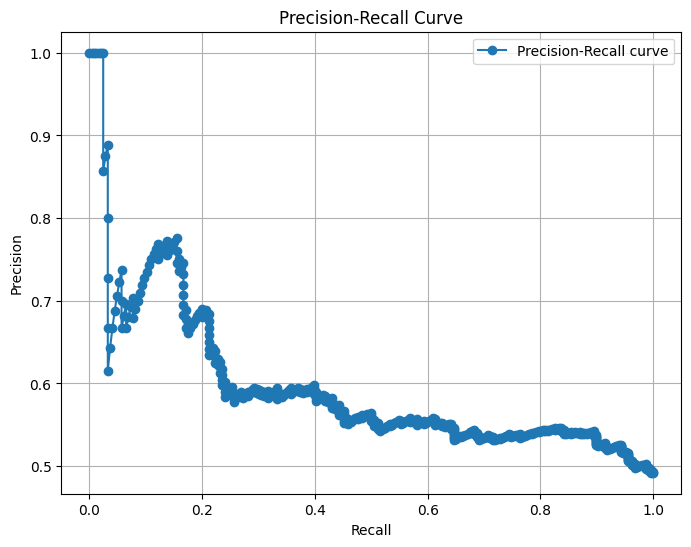

In [14]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions.predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', label='Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


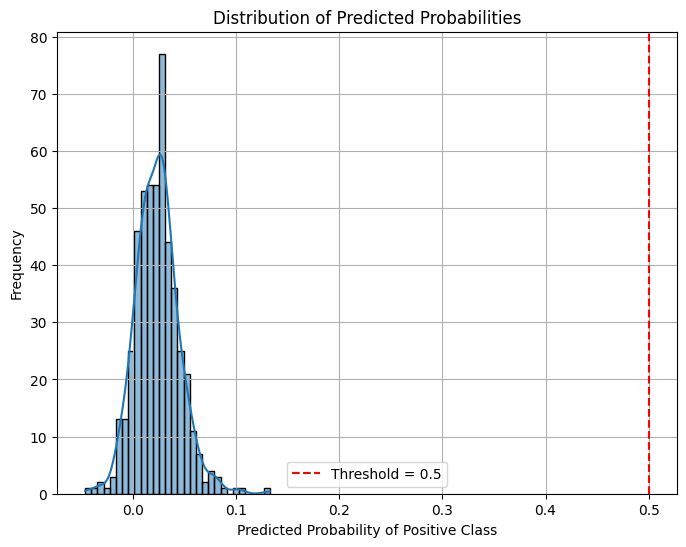

In [17]:
# Get predicted probabilities for the positive class
predicted_probs = predictions.predictions[:, 1]

plt.figure(figsize=(8, 6))
sns.histplot(predicted_probs, bins=30, kde=True)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid()
plt.show()


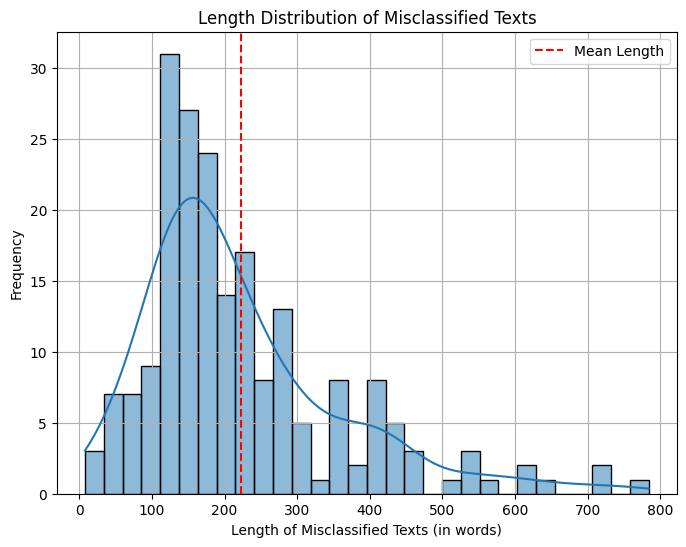

In [20]:
# Get indices of misclassified examples
misclassified_indices = np.where(pred_labels != true_labels)[0]  # Get indices where predictions don't match true labels

# Analyze lengths of misclassified examples
misclassified_texts = [dataset['test'][int(idx)]['text'] for idx in misclassified_indices]  # Convert to int
lengths = [len(text.split()) for text in misclassified_texts]

# Plot the length distribution of misclassified texts
plt.figure(figsize=(8, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.axvline(x=np.mean(lengths), color='red', linestyle='--', label='Mean Length')
plt.xlabel('Length of Misclassified Texts (in words)')
plt.ylabel('Frequency')
plt.title('Length Distribution of Misclassified Texts')
plt.legend()
plt.grid()
plt.show()


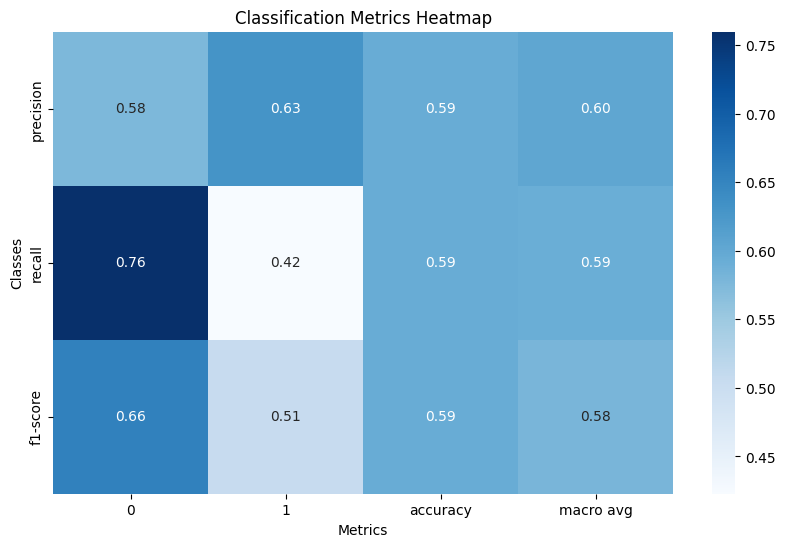

In [18]:
import seaborn as sns

# Create a heatmap for classification report metrics
classification_metrics = classification_report(true_labels, pred_labels, output_dict=True)
df_metrics = pd.DataFrame(classification_metrics).iloc[:-1, :-1]  # Exclude 'accuracy' row and 'support' column

plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()
